# Analysing Results

To run this experiment, first start by generating 100 configurations (the first is the default configuration, which means 99 are sampled randomly):
```console
lcdb create -w lcdb.workflow.sklearn.LibSVMWorkflow -n 100 -o configs.csv
```
This will create the `config.csv` file.


Then run the experiment using these configurations:
```console
lcdb run --openml-id 3 -w lcdb.workflow.sklearn.LibSVMWorkflow --monotonic --max-evals 100 -t 1800 --initial-configs configs.csv
```
this will create the `results.csv` file.

In [35]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deephyper.analysis import rank
from deephyper.analysis._matplotlib import update_matplotlib_rc, figure_size

update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [36]:
# Check the configs.csv to see if the same configuration are indeed evaluated
ip_df = pd.read_csv("configs.csv")
ip_df

,C,class_weight,dual,fit_intercept,intercept_scaling,loss,max_iter,multiclass,penalty,pp_cat_encoder,pp_decomposition,pp_featuregen,pp_featureselector,pp_scaler,tol
0,1.000000e+00,none,True,True,1.000000,squared_hinge,1000,ovr,l2,ordinal,none,none,generic,none,0.001000
1,5.370377e-07,none,True,True,234.566810,squared_hinge,1268,ovr,l2,onehot,fastica,poly2,select75,none,0.154191
2,1.551804e-07,none,True,True,4.759580,hinge,3804,ovr,l2,onehot,kernelpca,poly3,none,minmax,0.146655
3,4.958401e-10,balanced,True,False,38.497948,hinge,126,ovr,l2,ordinal,kernelpca,poly2,generic,minmax,0.002627
4,4.736543e+04,none,False,True,367.782674,squared_hinge,2006,ovo-scikit,l1,ordinal,ka_rbf,none,select50,minmax,0.064744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.820226e+09,balanced,True,True,11.058102,hinge,1140,ovo-scikit,l2,ordinal,kernelpca,poly3,none,std,0.003549
96,6.954518e-04,none,True,False,1.309587,squared_hinge,1221,ovo-scikit,l2,onehot,ka_nystroem,poly2,select90,none,0.002447
97,4.878759e+00,none,False,True,1.098526,squared_hinge,564,ovr,l2,onehot,ka_rbf,poly3,select50,none,0.000407
98,3.925353e-06,none,True,False,194.879020,hinge,331,ovr,l2,ordinal,none,poly2,generic,minmax,0.014612


In [37]:
def prepare_df(df):
    """Prepare the dataframe for analysis. For example, load the arrays/list from json format.
    """

    # Convert the string to JSON
    str_to_json = lambda x: x.replace("'", '"').replace("nan", "NaN").replace("inf", "Infinity")
    load_json = lambda x: json.loads(str_to_json(x))
    load_array = lambda x: np.array(load_json(x))

    # Load the arrays
    columns = ["m:fidelity_values", "m:score_types", "m:score_values"]
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(load_array)

    # Load the dicts
    columns = ["m:child_fidelities"]
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(load_json)

    return df

In [38]:
# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
r_df = pd.read_csv("results.csv")
r_df_failed = r_df[[v == "F" for v in r_df["objective"]]]

r_df = r_df[[v != "F" for v in r_df["objective"]]]
r_df.sort_values("job_id", inplace=True)

r_df = prepare_df(r_df)
r_df

,p:C,p:class_weight,p:dual,p:fit_intercept,p:intercept_scaling,p:loss,p:max_iter,p:multiclass,p:penalty,p:pp_cat_encoder,...,m:child_fidelities,m:dataset_id,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:workflow_seed,m:traceback
0,1.000000e+00,none,True,True,1.000000,squared_hinge,1000,ovr,l2,ordinal,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
23,5.370377e-07,none,True,True,234.566810,squared_hinge,1268,ovr,l2,onehot,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,"Traceback (most recent call last):\n File ""/U..."
47,1.551804e-07,none,True,True,4.759580,hinge,3804,ovr,l2,onehot,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
9,4.958401e-10,balanced,True,False,38.497948,hinge,126,ovr,l2,ordinal,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
2,4.736543e+04,none,False,True,367.782674,squared_hinge,2006,ovo-scikit,l1,ordinal,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,3.231347e+06,balanced,True,False,251.407968,squared_hinge,480,ovr,l2,onehot,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
92,9.068990e-06,balanced,True,False,5.241184,hinge,882,ovo-scikit,l2,onehot,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
95,5.631335e-07,balanced,False,False,23.241070,squared_hinge,3150,ovr,l2,onehot,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
96,1.205148e-06,balanced,True,True,127.936845,hinge,1849,ovr,l2,onehot,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN


In [40]:
idx = 0
print(r_df_failed.iloc[idx])
print(r_df_failed.iloc[idx]["m:traceback"])

p:C                                                              0.008354
p:class_weight                                                   balanced
p:dual                                                              False
p:fit_intercept                                                     False
p:intercept_scaling                                              3.036426
p:loss                                                      squared_hinge
p:max_iter                                                           4890
p:multiclass                                                   ovo-scikit
p:penalty                                                              l1
p:pp_cat_encoder                                                  ordinal
p:pp_decomposition                                           agglomerator
p:pp_featuregen                                                      none
p:pp_featureselector                                              generic
p:pp_scaler                           

In [41]:
sorted(r_df["objective"])

['0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.54062',
 '0.54688',
 '0.55312',
 '0.59375',
 '0.59688',
 '0.61875',
 '0.62187',
 '0.65312',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.7',
 '0.70625',
 '0.70938',
 '0.72812',
 '0.73438',
 '0.775',
 '0.85625',
 '0.85625',
 '0.86562',
 '0.87812',
 '0.8875',
 '0.89062',
 '0.89688',
 '0.91875',
 '0.925',
 '0.925',
 '0.925',
 '0.92812',
 '0.93125',
 '0.93438',
 '0.9375',
 '0.94062',
 '0.94375',
 '0.94688',
 '0.94688',
 '0.95',
 '0.95',
 '0.95',
 '0.95',
 '0.95312',
 '0.95625',
 '0.95625',
 '0.95625',
 '0.95625',
 '0.95625',
 '0.95625',
 '0.95

In [42]:
# Check the columns
r_df.columns.to_list()

['p:C',
 'p:class_weight',
 'p:dual',
 'p:fit_intercept',
 'p:intercept_scaling',
 'p:loss',
 'p:max_iter',
 'p:multiclass',
 'p:penalty',
 'p:pp_cat_encoder',
 'p:pp_decomposition',
 'p:pp_featuregen',
 'p:pp_featureselector',
 'p:pp_scaler',
 'p:tol',
 'objective',
 'job_id',
 'm:timestamp_submit',
 'm:timestamp_gather',
 'm:timestamp_start',
 'm:timestamp_end',
 'm:memory',
 'm:fidelity_unit',
 'm:fidelity_values',
 'm:score_types',
 'm:score_values',
 'm:time_types',
 'm:time_values',
 'm:child_fidelities',
 'm:dataset_id',
 'm:workflow',
 'm:valid_prop',
 'm:test_prop',
 'm:monotonic',
 'm:valid_seed',
 'm:test_seed',
 'm:workflow_seed',
 'm:traceback']

In [43]:
# Cumulated time
duration_wo_overheads = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).sum()
print(f"Cumulated time (without submit/gather overheads): {duration_wo_overheads:.2f} s.")

duration_w_overheads = (r_df["m:timestamp_gather"] - r_df["m:timestamp_submit"]).sum()
print(f"Cumulated time (with submit/gather overheads)   : {duration_w_overheads:.2f} s.")

ratio_overheads = (duration_w_overheads - duration_wo_overheads) / duration_wo_overheads
print(f"Overheads accounted for {ratio_overheads*100:.2f} % of the total time.\n")

# Real time
duration_run = (r_df["m:timestamp_gather"].max() - r_df["m:timestamp_submit"].min())
print(f"Real time of execution: {duration_run:.2f} s.")

Cumulated time (without submit/gather overheads): 686.47 s.
Cumulated time (with submit/gather overheads)   : 717.05 s.
Overheads accounted for 4.45 % of the total time.

Real time of execution: 113.28 s.


In [44]:
duration_job_mean = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).mean()
duration_job_std  = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).std()

print(f"Mean time per job: {duration_job_mean:.2f} s.")
print(f"Std  time per job: {duration_job_std:.2f} s.")

Mean time per job: 7.08 s.
Std  time per job: 11.40 s.


In [45]:
keys = ["m:fidelity_unit", "m:fidelity_values", "m:score_types"] 

for k in keys:
    print(f"{k[2:]}: {r_df[k][0]}")

fidelity_unit: samples
fidelity_values: [  16   23   32   45   64   91  128  181  256  362  512  724 1024 1448
 2048 2556]
score_types: ['accuracy' 'loss']


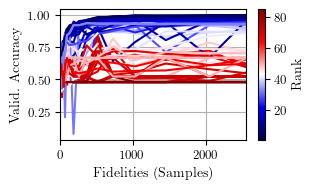

In [46]:
# Meaning of indexes
# fidelities, (train|valid|test), (accuracy|loss)

# Configuration of the plot
selected_split = "valid"
selected_score = "accuracy"

# Plotting
score_types = r_df["m:score_types"][0].tolist()
splits = ["train", "valid", "test"]
unit = r_df['m:fidelity_unit'][0]

idx_split = splits.index(selected_split)
idx_score = score_types.index(selected_score)

cmap = mpl.colormaps["seismic"]

fig = plt.figure()

# corresponds to iloc indexing
scores_max_fidelity = r_df["m:score_values"].map(lambda x: x[-1, idx_split, idx_score]).to_numpy()
ranking = rank(-scores_max_fidelity, decimals=3)
ranking_max = ranking.max()
for i in range(len(r_df)):
    fidelities = r_df.iloc[i]["m:fidelity_values"]
    scores = r_df.iloc[i]["m:score_values"][:, idx_split, idx_score]
    plt.plot(fidelities, scores, color=cmap(ranking[i]/ranking_max))

plt.xlabel(f"Fidelities ({unit.capitalize()})")
plt.ylabel(f"{selected_split.capitalize()}. {selected_score.capitalize()}")

plt.grid()

norm = mpl.cm.ScalarMappable(norm=None, cmap=cmap)
norm.set_clim(1, ranking_max)
cb = plt.colorbar(norm, ax=plt.gca(), label="Rank")
plt.xlim(0, fidelities.max())

plt.tight_layout()
plt.savefig(f"{unit}_{selected_split}-{selected_score}.png")
plt.show()